# Project Luther

## Summary:

In this project I have gathered data from the MLB in hopes that I can use a linear regression model to accurately predict the salary of any given player based soley on their stats.  

In [238]:
from __future__ import print_function, division
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn import feature_selection as f_select
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
import re
%matplotlib inline

In [744]:
def adj_r2_score(model,y,yhat):
        """Adjusted R square — put fitted linear model, y value, estimated y value in order
        
            Example:
            In [142]: metrics.r2_score(diabetes_y_train,yhat)
            Out[142]: 0.51222621477934993
        
            In [144]: adj_r2_score(lm,diabetes_y_train,yhat)
            Out[144]: 0.50035823946984515"""
        from sklearn import metrics
        adj = 1 - float(len(y)-1)/(len(y)-len(model.coef_)-1)*(1 - metrics.r2_score(y,yhat))
        return adj


## Gathering the data

In this section I will use the beautiful soup and Selenium packages to scrape my data from the internet.

## Beautiful Soup

In [ ]:
url = 'http://www.spotrac.com/mlb/statistics/player/' #webiste containing the data

response = requests.get(url)

In [ ]:
response.status_code

In [ ]:
page = response.text

In [ ]:
soup = BeautifulSoup(page,"lxml")

In [ ]:
#collects data and puts it in something we can work with

tables=soup.find_all("table")
rows=[row for row in tables[0].find_all('tr')]

# Just want to look at 1st 20 rows for now
rows=rows[1:]

batters={}
for row in rows:
    items=row.find_all('td')
    player=items[1].find('a')
    batters[player]=[i.text for i in items]
    

list(batters.items())
len(batters)

In [ ]:
#will change the string of dollars into an integer that we can work with.
def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '').replace(' ','')
    return int(moneystring)

In [ ]:
i = 0
batlist = []
while i < len(batters):
    batlist.append(list(batters.items())[i][1])
    i = i + 1

In [ ]:
#splits the name and position into different elements of the list.
i = 0
while i < len(batlist):
    batlist[i].extend(batlist[i][1].split(' '))
    i = i + 1

In [ ]:
#removes the name string from the front

i = 0
while i < len(batlist):
    batlist[i] = batlist[i][:1]+batlist[i][2:]
    i = i + 1

In [ ]:
#removes the period from the last names

i = 0
while i < len(batlist):
    batlist[i][-2] = batlist[i][-2].replace('.','')
    i = i + 1

In [ ]:
#converts the salary string into an integer
i = 0
while i < len(batlist):
    batlist[i][16] = money_to_int(batlist[i][16])
    i = i + 1

In [ ]:
#sets up the headers and creates a data frame
Headers = ['RANK', 'TEAM', 'GP', 'AB', 'H', 'R', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS', 'SALARY', 'FIRST', 'LAST', 'POSITION']
batdf = pd.DataFrame(batlist)

In [ ]:
batdf.columns = Headers

## Selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

import os

In [ ]:
chromedriver = "/Users/gilliangoodman/Downloads/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

driver = webdriver.Chrome(chromedriver)
driver.get("http://www.spotrac.com/mlb/statistics/player/")

In [ ]:
soup2 = BeautifulSoup(driver.page_source, 'html.parser')

In [ ]:
#collects the data from the html and puts it in something we can work with

tables=soup2.find_all("table")
rows=[row for row in tables[0].find_all('tr')]


rows=rows[1:]

pitchers={}
for row in rows:
    items=row.find_all('td')
    player=items[1].find('a')
    pitchers[player]=[i.text for i in items]
    

list(pitchers.items())

In [ ]:
#removes the key and makes the rest into a list of lists

i = 0
pitchlist = []
while i < len(pitchers):
    pitchlist.append(list(pitchers.items())[i][1])
    i = i + 1

In [ ]:
#adds the first and last names and posistion to the end of each list

i = 0
while i < len(pitchlist):
    pitchlist[i].extend(pitchlist[i][1].split(' '))
    i = i + 1

In [ ]:
#removes the name string from the begining 

i = 0
while i < len(pitchlist):
    pitchlist[i] = pitchlist[i][:1]+pitchlist[i][2:]
    i = i + 1

In [ ]:
#change the string salary into an integer

i = 0
while i < len(pitchlist):
    pitchlist[i][15] = money_to_int(pitchlist[i][15])
    i = i + 1

In [ ]:
#remove the period from the last name

i = 0
while i < len(pitchlist):
    pitchlist[i][-2] = pitchlist[i][-2].replace('.','')
    i = i + 1

In [ ]:
#lay out headers and create my data frame

Headers2 = ['RANK', 'TEAM', 'GP', 'GS', 'IP', 'H', 'R', 'ER', 'BB', 'SO', 'W', 'L', 'SV', 'ERA', 'WHIP', 'SALARY', 'FIRST', 'LAST', 'POSITION']
pitchdf = pd.DataFrame(pitchlist)

In [ ]:
#needed to drop a player because his name added unnecessary columns.  jorge de la hoya name is in an abnormal 
#structure so it was easier to delete.  this should not affect the data much.

pitchdf.drop(pitchdf.index[145])

In [ ]:
pitchdf = pitchdf.drop([19, 20], 1)

In [ ]:
pitchdf.columns = Headers2

In [ ]:
#Now that we have our data frames we need to convert the number entries into floats 

pitchdf[['GP', 'GS', 'IP', 'H', 'R', 'ER', 'BB', 'SO', 'W', 'L', 'SV', 'ERA', 'WHIP']] = pitchdf[['GP', 'GS', 'IP', 'H', 'R', 'ER', 'BB', 'SO', 'W', 'L', 'SV', 'ERA', 'WHIP']].convert_objects(convert_numeric=True)

In [ ]:
Now lets do the same thing for the batters
batdf[['GP', 'AB', 'H', 'R', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS']] = batdf[['GP', 'AB', 'H', 'R', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS']].convert_objects(convert_numeric=True)

In [ ]:
starters = pitchdf[pitchdf['POSITION'] == 'SP']

My  exploratory analysis can be found in the file project_luther where I discover that this data set doesn't have all of the information necessary.

## Gathering data part two

Unfortunately the data that I scraped did not include a very important statistic, age.  Luckily I found another source that was available to download on a csv file.

In [1138]:
pitching = pd.read_csv('Pitchingdata.csv')
batting = pd.read_csv('battersdata.csv')
salaries = pd.read_csv('salariesdata.csv')

In [1139]:
salaries = salaries.drop(["Pos'n", "MLS"], axis=1)

In [1140]:
salaries['Player']

0        Kershaw, Clayton
1           Greinke, Zack
2            Price, David
3          Hamilton, Josh
4          Heyward, Jason
5         Cabrera, Miguel
6       Verlander, Justin
7        Hernandez, Felix
8          Pujols, Albert
9            Sabathia, CC
10            Lester, Jon
11         Cano, Robinson
12           Hamels, Cole
13          Cueto, Johnny
14             Mauer, Joe
15        Ramirez, Hanley
16       Cespedes, Yoenis
17       Gonzalez, Adrian
18          Posey, Buster
19          Scherzer, Max
20          Upton, Justin
21            Reyes, Jose
22            Votto, Joey
23       Tanaka, Masahiro
24         Crawford, Carl
25             Kemp, Matt
26          Werth, Jayson
27            Reyes, Jose
28       Ellsbury, Jacoby
29           Davis, Chris
              ...        
860      Rodriguez, Joely
861     Kivlehan, Patrick
862       Campos, Vicente
863      Mejia, Adalberto
864       Rivero, Armando
865    Santander, Anthony
866           Taylor, Ben
867         

In [1141]:
batting['Name']

0              Fernando Abad*\abadfe01
1                 Jose Abreu\abreujo02
2          Cristhian Adames#\adamecr01
3               Austin Adams\adamsau02
4                 Lane Adams\adamsla01
5                Matt Adams*\adamsma01
6                Matt Adams*\adamsma01
7                Matt Adams*\adamsma01
8                Jim Adduci*\adducji02
9                Tim Adleman\adlemti01
10           Ehire Adrianza#\adriaeh01
11             Jesus Aguilar\aguilje01
12                Nick Ahmed\ahmedni01
13             Andrew Albers\alberan01
14              Matt Albers*\alberma01
15             Ozzie Albies#\albieoz01
16           Al Alburquerque\albural01
17           Al Alburquerque\albural01
18      Arismendy Alcantara#\alcanar01
19           Sandy Alcantara\alcansa01
20          Scott Alexander*\alexasc02
21              Jorge Alfaro\alfarjo01
22            Anthony Alford\alforan01
23                Cody Allen\allenco01
24               Greg Allen#\allengr01
25          Abraham Almon

In [1142]:
#lets remove all of those nasty characters from our names so we can merge easily
from string import printable

batting['Name'] = batting['Name'].apply(lambda x: x.split('*',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: x.split('#',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: x.split('\\',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: re.sub("[^{}]+".format(printable), " ", x))
batting['Name'] = batting['Name'].apply(lambda x: x.split(' ',1)[-1] + ',' + ' ' + x.split(' ',1)[0])

In [1143]:
batting['Name']

0             Abad, Fernando
1                Abreu, Jose
2          Adames, Cristhian
3              Adams, Austin
4                Adams, Lane
5                Adams, Matt
6                Adams, Matt
7                Adams, Matt
8                Adduci, Jim
9               Adleman, Tim
10           Adrianza, Ehire
11            Aguilar, Jesus
12               Ahmed, Nick
13            Albers, Andrew
14              Albers, Matt
15             Albies, Ozzie
16          Alburquerque, Al
17          Alburquerque, Al
18      Alcantara, Arismendy
19          Alcantara, Sandy
20          Alexander, Scott
21             Alfaro, Jorge
22           Alford, Anthony
23               Allen, Cody
24               Allen, Greg
25          Almonte, Abraham
26            Almora, Albert
27            Alonso, Yonder
28            Alonso, Yonder
29            Alonso, Yonder
                ...         
1424            Wong, Kolten
1425              Wood, Alex
1426             Wood, Blake
1427          

In [1144]:
#Lets do the same thing with the pitching data
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('*',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('#',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('\\',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: re.sub("[^{}]+".format(printable), " ", x))
pitching['Name'] = pitching['Name'].apply(lambda x: x.split(' ',1)[-1] + ',' + ' ' + x.split(' ',1)[0])


In [1145]:
pitching['Name']

0            Abad, Fernando
1             Adams, Austin
2              Adleman, Tim
3            Albers, Andrew
4              Albers, Matt
5          Alburquerque, Al
6          Alburquerque, Al
7          Alburquerque, Al
8           Alcantara, Raul
9          Alcantara, Sandy
10        Alcantara, Victor
11         Alexander, Scott
12              Allen, Cody
13          Almonte, Miguel
14           Altavilla, Dan
15           Alvarado, Jose
16           Alvarez, Dario
17       Alvarez, Henderson
18            Alvarez, Jose
19          Anderson, Brett
20          Anderson, Brett
21          Anderson, Brett
22          Anderson, Chase
23           Anderson, Drew
24          Anderson, Tyler
25           Andriese, Matt
26          Aoki, Norichika
27           Aquino, Jayson
28            Arano, Victor
29            Archer, Chris
               ...         
892            Winkler, Dan
893            Wisler, Matt
894          Wittgren, Nick
895    Wojciechowski, Asher
896              Woo

In [1146]:
#narrow down our sample to only players with more than 200 at bats this year
batting2 = batting[batting['AB'] >= 200]

In [1147]:
#narrow down our sample to only players with more than 30 games played this year
pitching2 = pitching[pitching['G'] >= 30]

In [1148]:
salaries.rename(columns={'Player':'Name', '2017' : 'Salary'},inplace = True)

In [1149]:
def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '').replace(' ','')
    return int(moneystring)

In [1150]:
salaries['Salary'] = salaries['Salary'].apply(lambda x: money_to_int(x))

In [1151]:
#lets merge our salaries dataframe with our pitching dataframe 

pitchdf = pd.merge(salaries, pitching2, on=['Name'])

In [1152]:
batdf = pd.merge(salaries, batting2, on=['Name'])

In [1153]:
batdf.columns[30]

'Pos\xa0Summary'

In [1154]:
batdf.drop_duplicates('Name', inplace = True)

In [1155]:
batdf = batdf.drop(['Rk', 'Tm', 'Lg', 'Pos\xa0Summary'],1)

In [1156]:
pitchdf.drop_duplicates('Name', inplace = True)

In [1157]:
pitchdf = pitchdf.drop(['Rk', 'Tm', 'Lg'],1)

In [1158]:
batdf['intercept'] = 1
pitchdf['intercept'] = 1

In [1159]:
pitchdf.corr()

,Salary,Age,W,L,W-L%,ERA,G,GS,GF,CG,...,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,intercept
Salary,1.000000,0.373189,0.433273,0.389039,0.016402,0.005547,-0.350293,0.473351,-0.141373,0.346680,...,0.452400,0.054991,-0.026405,-0.133880,-0.016048,0.118214,-0.216016,0.050844,0.217138,NaN
Age,0.373189,1.000000,-0.068667,-0.008345,-0.059979,0.052522,0.068180,-0.027509,-0.029084,0.051132,...,-0.038581,-0.033776,0.075806,-0.035610,0.005421,0.085880,-0.068982,-0.077239,0.027618,NaN
W,0.433273,-0.068667,1.000000,0.611439,0.290878,-0.068522,-0.554933,0.835978,-0.427723,0.462779,...,0.855482,0.005494,-0.003154,-0.112993,0.017639,0.042167,-0.228140,-0.115141,0.063490,NaN
L,0.389039,-0.008345,0.611439,1.000000,-0.371310,0.276107,-0.557348,0.830938,-0.362769,0.380076,...,0.842886,-0.292415,0.252901,0.202024,0.311484,0.219085,-0.107272,-0.296271,-0.119242,NaN
W-L%,0.016402,-0.059979,0.290878,-0.371310,1.000000,-0.308612,-0.011804,-0.023138,-0.075982,0.033437,...,-0.035562,0.307650,-0.241642,-0.318840,-0.308357,-0.158914,-0.106730,0.179857,0.221614,NaN
ERA,0.005547,0.052522,-0.068522,0.276107,-0.308612,1.000000,-0.414439,0.186806,-0.261435,-0.014462,...,0.113151,-0.882946,0.740060,0.769089,0.736778,0.639614,0.271183,-0.393171,-0.444568,NaN
G,-0.350293,0.068180,-0.554933,-0.557348,-0.011804,-0.414439,1.000000,-0.753535,0.552777,-0.336870,...,-0.640132,0.391566,-0.374471,-0.268073,-0.360323,-0.368468,0.061512,0.283647,0.133892,NaN
GS,0.473351,-0.027509,0.835978,0.830938,-0.023138,0.186806,-0.753535,1.000000,-0.545358,0.472028,...,0.976892,-0.219684,0.212558,0.097568,0.235137,0.209534,-0.178891,-0.279802,-0.055188,NaN
GF,-0.141373,-0.029084,-0.427723,-0.362769,-0.075982,-0.261435,0.552777,-0.545358,1.000000,-0.249362,...,-0.490541,0.326459,-0.303616,-0.229860,-0.284794,-0.212156,0.015802,0.329671,0.215919,NaN
CG,0.346680,0.051132,0.462779,0.380076,0.033437,-0.014462,-0.336870,0.472028,-0.249362,1.000000,...,0.494042,-0.026454,0.029145,-0.064509,0.049426,0.078479,-0.190725,-0.100535,0.061236,NaN


In [1160]:
batdf.corr()

,Salary,Age,G,PA,AB,R,H,2B,3B,HR,...,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,intercept
Salary,1.000000,0.614947,0.084252,0.224861,0.204336,0.197061,0.205408,0.166697,-0.090181,0.136706,...,0.092653,0.132480,0.134215,0.190245,0.293039,0.012459,-0.167252,0.167397,0.205933,NaN
Age,0.614947,1.000000,-0.121059,-0.079795,-0.095957,-0.114183,-0.118144,-0.086047,-0.211711,-0.097755,...,-0.108292,-0.081726,-0.082453,-0.132524,0.083086,0.053219,-0.083489,0.027551,-0.091666,NaN
G,0.084252,-0.121059,1.000000,0.901057,0.895695,0.773676,0.815214,0.687224,0.289284,0.561015,...,0.299858,0.305253,0.297578,0.805556,0.494092,0.214022,0.020452,0.401680,0.352083,NaN
PA,0.224861,-0.079795,0.901057,1.000000,0.990169,0.891514,0.932882,0.774386,0.315172,0.643876,...,0.402451,0.420311,0.420445,0.920145,0.553773,0.252023,-0.085829,0.438844,0.396347,NaN
AB,0.204336,-0.095957,0.895695,0.990169,1.000000,0.859470,0.943257,0.774161,0.328446,0.604791,...,0.365750,0.362200,0.361389,0.909209,0.569031,0.208646,-0.063409,0.425260,0.342883,NaN
R,0.197061,-0.114183,0.773676,0.891514,0.859470,1.000000,0.877092,0.732575,0.382568,0.708917,...,0.594472,0.630677,0.621923,0.917027,0.420172,0.274586,-0.124862,0.322862,0.426373,NaN
H,0.205408,-0.118144,0.815214,0.932882,0.943257,0.877092,1.000000,0.806804,0.363577,0.568290,...,0.501145,0.533806,0.535250,0.930540,0.574197,0.204043,-0.068112,0.416846,0.385592,NaN
2B,0.166697,-0.086047,0.687224,0.774386,0.774161,0.732575,0.806804,1.000000,0.206578,0.481805,...,0.490815,0.497149,0.483434,0.801476,0.459309,0.167937,-0.120831,0.399989,0.366652,NaN
3B,-0.090181,-0.211711,0.289284,0.315172,0.328446,0.382568,0.363577,0.206578,1.000000,0.006550,...,0.092161,0.123884,0.103134,0.290091,-0.081762,0.087896,0.177304,0.007000,0.088781,NaN
HR,0.136706,-0.097755,0.561015,0.643876,0.604791,0.708917,0.568290,0.481805,0.006550,1.000000,...,0.801743,0.712690,0.683121,0.821460,0.398849,0.193034,-0.316122,0.280360,0.417200,NaN


In [1161]:

est=LinearRegression()
x = batdf.drop(['Salary','Name'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = batdf['Salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
print(sig_cols)
print(np.mean(all_scores))
    

['Age', 'PA', 'AB', 'R', 'H', '2B', '3B', 'RBI', 'BB', 'OBP', 'TB', 'GDP', 'SH', 'SF', 'IBB']
0.441104369123


/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [1162]:
x = batdf[sig_cols]
y = batdf['Salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(lr, y, lr.predict(x)))
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
zipped=zip(x.columns,lr.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]


Fit score (R^2) is: 0.508518
Adj R^2 is: 0.481807
Fit intercept is: -30240470.354932
Mean of the target value is: 6247631.760274


[('OBP', -4833597.8248722712),
 ('Age', 1148907.7147616239),
 ('IBB', 338390.73134835658),
 ('SF', 218693.75770972169),
 ('SH', -171889.12139191228),
 ('BB', 146493.71336068207),
 ('PA', -130749.92805215913),
 ('AB', 128979.82071878511),
 ('3B', -97319.101205080282),
 ('GDP', 87942.057154099195)]

Text(336.971,0.5,'Predicted outcome')

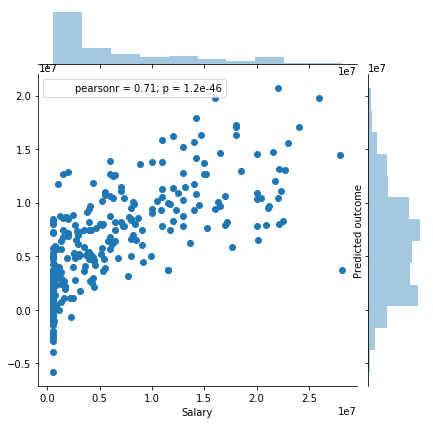

In [1163]:
x = batdf[sig_cols]
y = batdf['Salary']
lr = LinearRegression()
fit = lr.fit(x,y)
y_predicted = fit.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

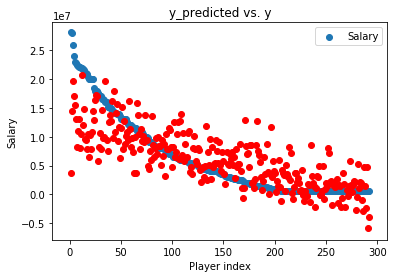

In [1164]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('Salary')
plt.title('y_predicted vs. y')
plt.legend()

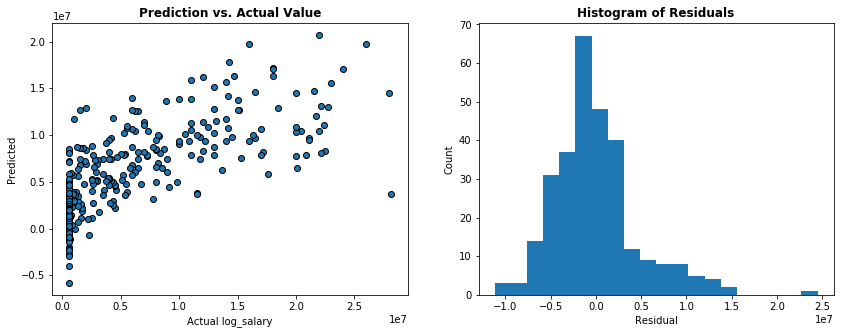

In [1165]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');

In [1166]:
pitchdf.columns[3:]

Index(['W', 'L', 'W-L%', 'ERA', 'G', 'GS', 'GF', 'CG', 'SHO', 'SV', 'IP', 'H',
       'R', 'ER', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'BK', 'WP', 'BF', 'ERA+',
       'FIP', 'WHIP', 'H9', 'HR9', 'BB9', 'SO9', 'SO/W', 'intercept'],
      dtype='object')

In [1167]:
pitchdf = pitchdf.dropna()
est=LinearRegression()
x = pitchdf.drop(['Salary','Name'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = pitchdf['Salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 
# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
print(sig_cols)
print(np.mean(all_scores))
    

['Age', 'W', 'L', 'G', 'GS', 'GF', 'CG', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'SO', 'HBP', 'WP', 'BF', 'HR9', 'BB9', 'SO/W']
0.19920898874


/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [1168]:
x = pitchdf[sig_cols]
y = pitchdf['Salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(lr, y, lr.predict(x)))
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
zipped=zip(x.columns,lr.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]



Fit score (R^2) is: 0.565829
Adj R^2 is: 0.524082
Fit intercept is: -12707925.341220
Mean of the target value is: 4196622.720524


[('HR9', -3184770.547427631),
 ('BB9', 1284272.2709545263),
 ('Age', 536914.90397524124),
 ('HR', 481611.59694052616),
 ('SO/W', 367598.67549290397),
 ('GS', 347389.82168690825),
 ('R', 307217.72509788611),
 ('ER', -264553.54543060384),
 ('CG', 230729.99626456271),
 ('W', 218370.17977061166)]

Text(336.971,0.5,'Predicted outcome')

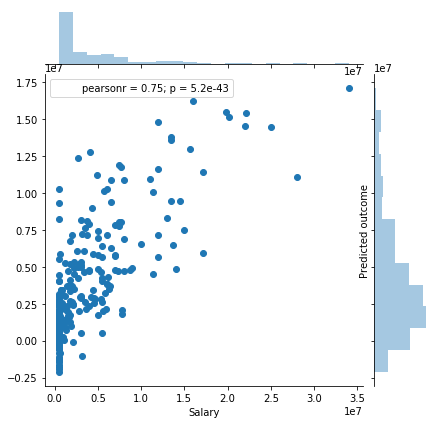

In [1169]:
x = pitchdf[sig_cols]
y = pitchdf['Salary']
lr = LinearRegression()
fit = lr.fit(x,y)
y_predicted = fit.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

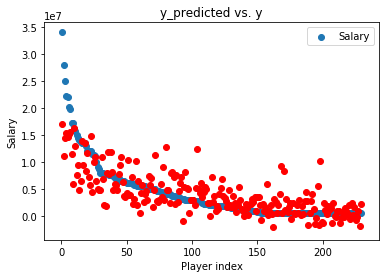

In [1170]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('Salary')
plt.title('y_predicted vs. y')
plt.legend()

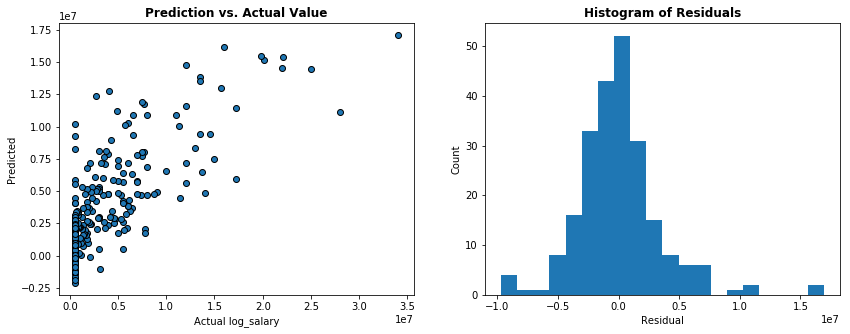

In [1171]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');

In [1172]:
#These are not the best fits so lets try again with logSalary
pitchdf['log_salary'] = np.log(pitchdf.Salary)
batdf['log_salary'] = np.log(batdf.Salary)

In [1173]:
est=LinearRegression()
x = batdf.drop(['Salary','Name', 'log_salary'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = batdf['log_salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
b1sig_cols = sig_cols
print(b1sig_cols)
print(np.mean(all_scores))

['Age', 'PA', 'AB', 'R', 'H', '2B', 'HR', 'RBI', 'BB', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'SH', 'SF', 'IBB']
0.546132084925


/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [1174]:
x = batdf[b1sig_cols]
y = batdf['log_salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(lr, y, lr.predict(x)))
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
zipped=zip(x.columns,lr.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]

Fit score (R^2) is: 0.614881
Adj R^2 is: 0.587979
Fit intercept is: 9.208197
Mean of the target value is: 14.892948


[('OPS', -92.624370644335698),
 ('SLG', 90.904950772205893),
 ('OBP', 89.454866463766905),
 ('BA', -7.8197835464046275),
 ('Age', 0.25734934817171484),
 ('SH', -0.072310777101670845),
 ('SF', 0.064211792979428292),
 ('IBB', 0.05096828023597455),
 ('H', 0.030394559569339216),
 ('GDP', 0.01927082725123342)]

In [1175]:
pitchdf = pitchdf.dropna()
est=LinearRegression()
x = pitchdf.drop(['Salary','Name', 'log_salary'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = pitchdf['log_salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
p1sig_cols = sig_cols
print(p1sig_cols)
print(np.mean(all_scores))

['Age', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'SO', 'HBP', 'WP', 'BF', 'WHIP', 'HR9', 'BB9', 'SO/W']
0.455115899292


/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [1176]:
x = pitchdf[p1sig_cols]
y = pitchdf['log_salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(lr, y, lr.predict(x)))
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
zipped=zip(x.columns,lr.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]

Fit score (R^2) is: 0.584877
Adj R^2 is: 0.542763
Fit intercept is: 8.473132
Mean of the target value is: 14.554615


[('HR9', -0.38316113673834346),
 ('WHIP', 0.26990000586940327),
 ('BB9', 0.17776443035171671),
 ('Age', 0.17329293156038605),
 ('SO/W', 0.13691268587998418),
 ('GS', 0.092321962047219763),
 ('L', 0.087319121380140863),
 ('HR', 0.058009132556372009),
 ('CG', 0.038540002973981982),
 ('R', 0.036397507138626994)]

Text(336.971,0.5,'Predicted outcome')

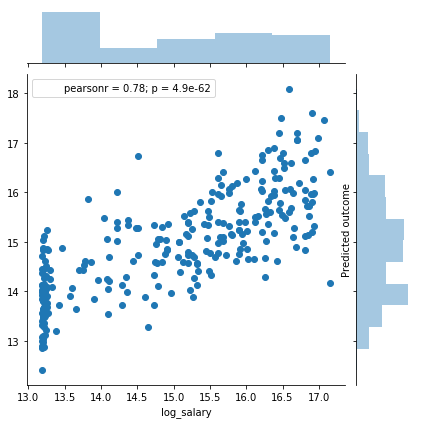

In [1177]:
x = batdf[b1sig_cols]
y = batdf['log_salary']
lr = LinearRegression()
fit = lr.fit(x,y)
y_predicted = fit.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

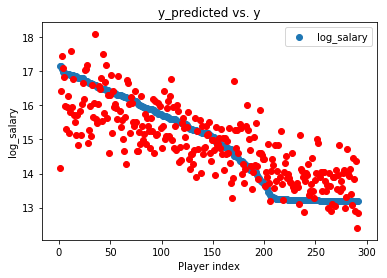

In [1178]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('log_salary')
plt.title('y_predicted vs. y')
plt.legend()

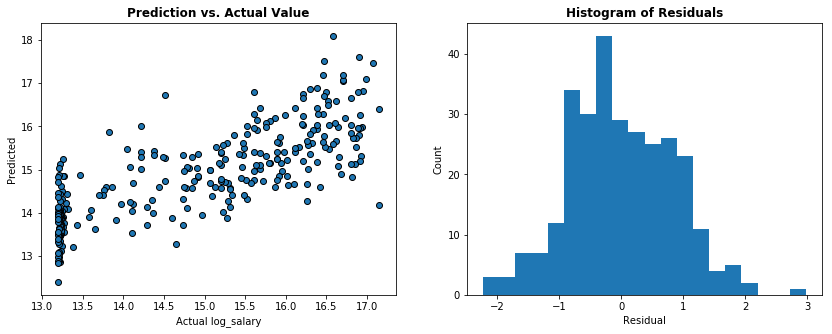

In [1179]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');



Text(336.971,0.5,'Predicted outcome')

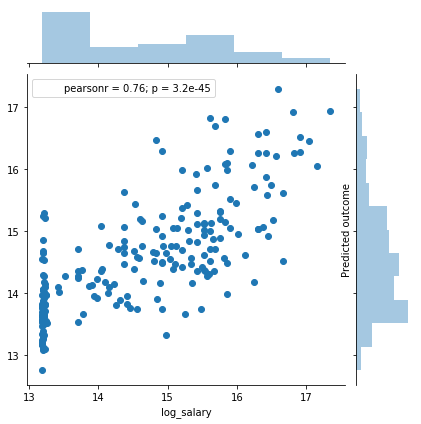

In [1180]:
x = pitchdf[p1sig_cols]
y = pitchdf['log_salary']
lr = LinearRegression()
fit = lr.fit(x,y)
y_predicted = fit.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

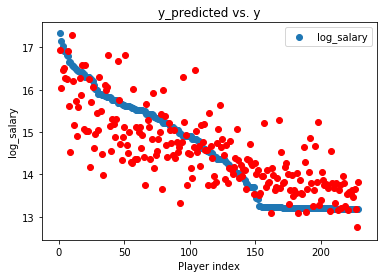

In [1181]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('log_salary')
plt.title('y_predicted vs. y')
plt.legend()

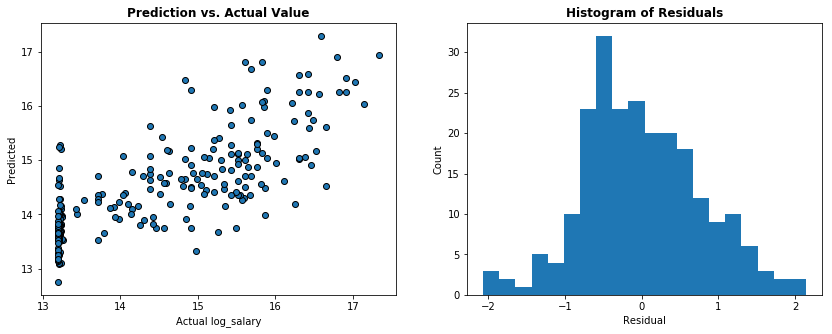

In [1182]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');



# Refining the model

### Data

As we can see above, there is a large portion of the data set that are being payed at or close to the MLB minimum.  I can reasonably assume that a large portion of these players are rookies and therefore being payed below their market value until their rookie contract expires.  That assumption makes them poor data points for this model and I will remove them.

In [1183]:
batdf2 = batdf[batdf['Salary'] > 570000]
pitchdf2 = pitchdf[pitchdf['Salary'] > 560000]

In [1184]:
print(len(batdf) - len(batdf2))
print(len(pitchdf) - len(pitchdf2))

76
73


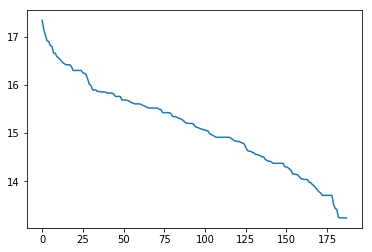

In [1185]:
plt.plot(pitchdf2['log_salary'])

(array([  7.,  15.,  17.,  16.,  24.,  33.,  17.,  15.,   9.,   3.]),
 array([ 13.24192261,  13.65191746,  14.06191231,  14.47190715,
         14.881902  ,  15.29189685,  15.70189169,  16.11188654,
         16.52188139,  16.93187624,  17.34187108]),
 <a list of 10 Patch objects>)

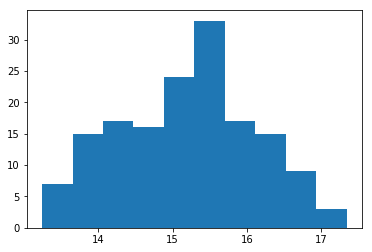

In [1186]:
plt.hist(pitchdf2['log_salary'])

0.043640390279


/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


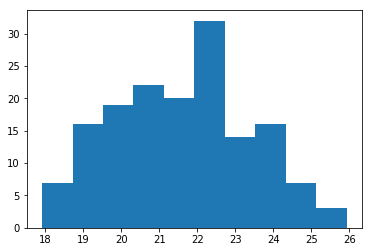

In [1187]:
from scipy import stats

lamb=stats.boxcox_normmax(pitchdf2.Salary, brack=(-1.9, 1.9))
print(lamb)
y_t=(np.power(pitchdf2.Salary,lamb)-1)/lamb

plt.hist(y_t);

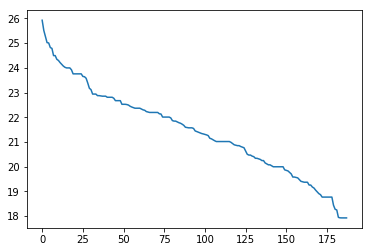

In [1188]:
plt.plot(y_t)

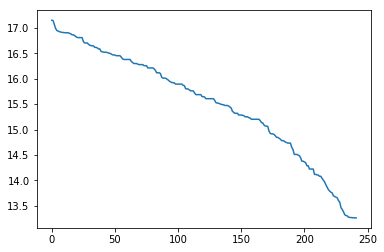

In [1189]:
plt.plot(batdf2['log_salary'])

(array([ 15.,   9.,  17.,  16.,  21.,  25.,  33.,  25.,  32.,  23.]),
 array([ 13.25724386,  13.64688446,  14.03652505,  14.42616565,
         14.81580624,  15.20544684,  15.59508743,  15.98472803,
         16.37436862,  16.76400922,  17.15364982]),
 <a list of 10 Patch objects>)

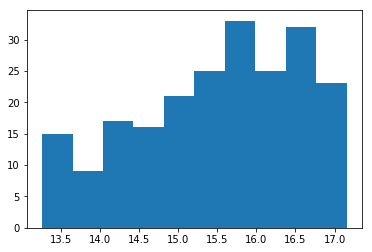

In [1190]:
plt.hist(batdf2['log_salary'])

0.29428319749


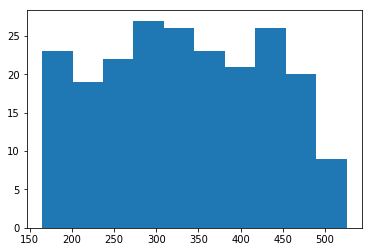

In [1191]:
from scipy import stats

lamb=stats.boxcox_normmax(batdf2.Salary, brack=(-1.9, 1.9))
print(lamb)
y_t=(np.power(batdf2.Salary,lamb)-1)/lamb

plt.hist(y_t);

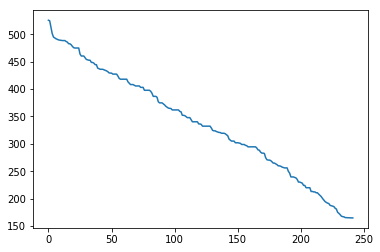

In [1192]:
plt.plot(y_t)

### Batting

In [1193]:
batdf2['salary_t'] = batdf2['Salary'] ** 0.29428319749

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1194]:
est=LinearRegression()
x = batdf2.drop(['Salary','Name', 'log_salary', 'salary_t'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = batdf2['salary_t']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
bsig_cols = sig_cols
print(bsig_cols)
print(np.mean(all_scores))

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


['Age', 'PA', 'AB', 'R', 'H', '2B', 'HR', 'RBI', 'BB', 'OBP', 'OPS+', 'TB', 'GDP', 'SH', 'SF', 'IBB']
0.349181477284


In [1195]:
x = batdf2[bsig_cols]
y = batdf2['salary_t']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(lr, y, lr.predict(x)))
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
zipped=zip(x.columns,lr.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]

Fit score (R^2) is: 0.443001
Adj R^2 is: 0.398217
Fit intercept is: -65.946710
Mean of the target value is: 99.682194


[('OBP', -106.3748479959299),
 ('Age', 5.0042161327054488),
 ('SH', -1.3526502918465564),
 ('IBB', 1.0743672856166941),
 ('SF', 1.0461625838378112),
 ('GDP', 0.67108916841719557),
 ('BB', 0.57439441168279681),
 ('HR', 0.55695132356553212),
 ('AB', 0.54608904279932036),
 ('PA', -0.52253410735609318)]

Text(336.971,0.5,'Predicted outcome')

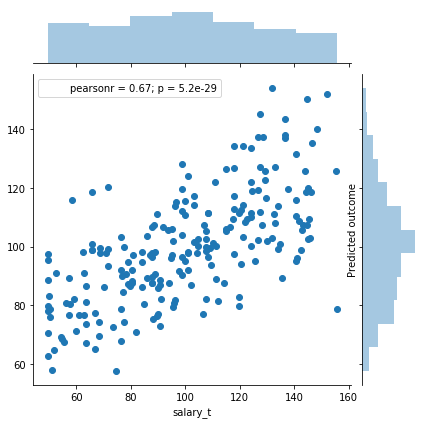

In [1196]:
x = batdf2[bsig_cols]
y = batdf2['salary_t']
lr = LinearRegression()
fit = lr.fit(x,y)
y_predicted = fit.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

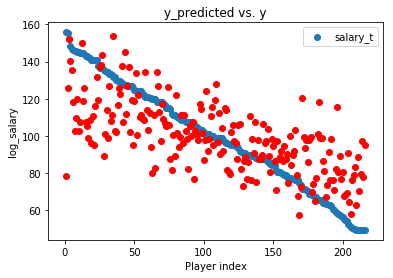

In [1197]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('log_salary')
plt.title('y_predicted vs. y')
plt.legend()

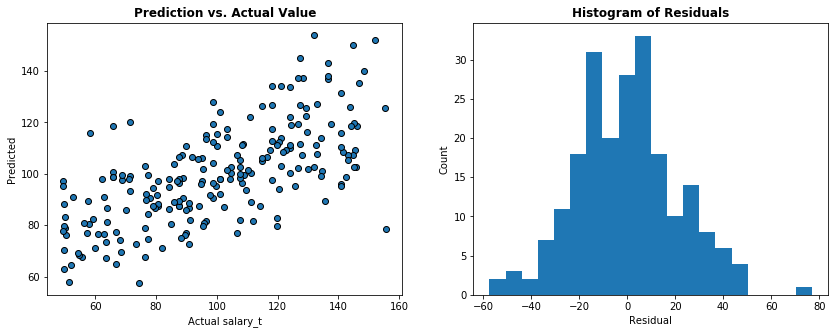

In [1198]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual salary_t')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');



### Pitching

In [1199]:
est=LinearRegression()
x = pitchdf2.drop(['Salary','Name', 'log_salary'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = pitchdf2['log_salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
psig_cols = sig_cols
print(psig_cols)
print(np.mean(all_scores))

['Age', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'SO', 'HBP', 'WP', 'BF', 'HR9', 'BB9', 'SO/W']
0.236879993846


/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [1200]:
x = pitchdf2[psig_cols]
y = pitchdf2['log_salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(lr, y, lr.predict(x)))
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
zipped=zip(x.columns,lr.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]

Fit score (R^2) is: 0.519193
Adj R^2 is: 0.447962
Fit intercept is: 12.963317
Mean of the target value is: 15.185675


[('HR9', -0.31176018435483605),
 ('SHO', -0.29162181633397333),
 ('CG', 0.21796301932571649),
 ('GS', 0.13780088423071707),
 ('SO/W', 0.1065812355174033),
 ('BB9', 0.10474978919465212),
 ('Age', 0.070552167890202508),
 ('L', 0.06739043014543894),
 ('HR', 0.057688584687951308),
 ('HBP', -0.048515486648979395)]

Text(336.971,0.5,'Predicted outcome')

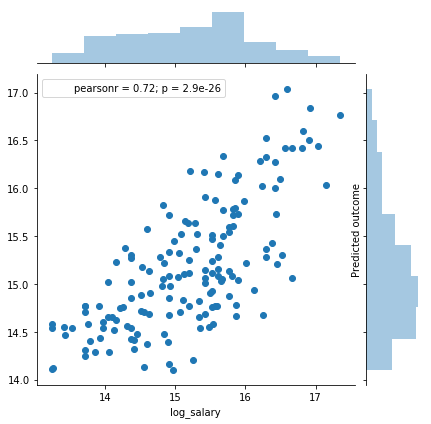

In [1201]:
x = pitchdf2[psig_cols]
y = pitchdf2['log_salary']
lr = LinearRegression()
fit = lr.fit(x,y)
y_predicted = fit.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

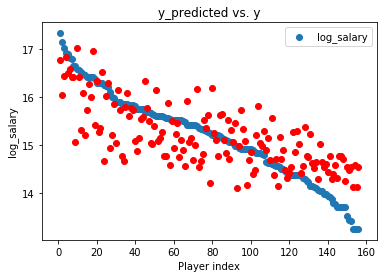

In [1202]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('log_salary')
plt.title('y_predicted vs. y')
plt.legend()

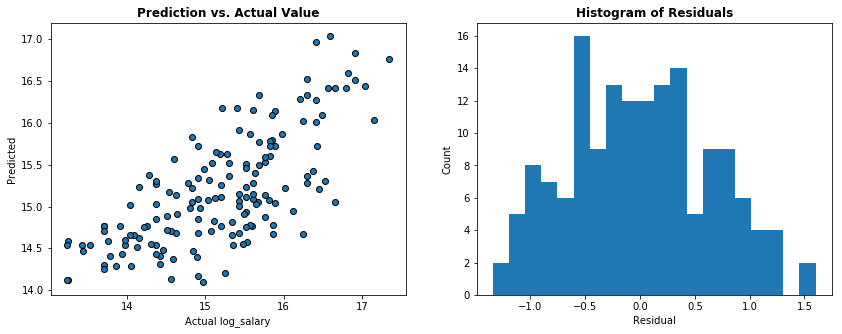

In [1203]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');



Manipulating the data appears to have worsened the overall fit of our model and its ability to predict unseen data. 

### Variables

I will now look at the variables to see if they might need to be transformed at all.

### Batting

In [1204]:
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((10, 20))
    ax.set_xlim((0, 20))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

x_plot = np.linspace(0, 15, 100)

In [1205]:
batdf.columns

Index(['Name', 'Salary', 'Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB',
       'GDP', 'HBP', 'SH', 'SF', 'IBB', 'intercept', 'log_salary'],
      dtype='object')

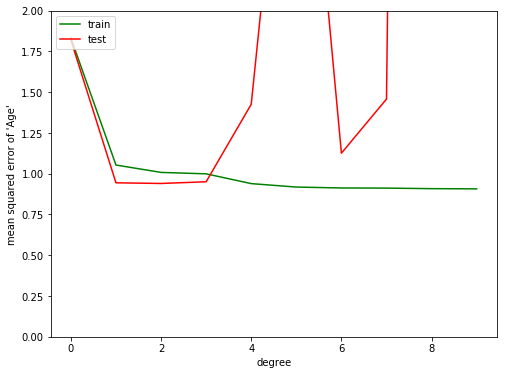

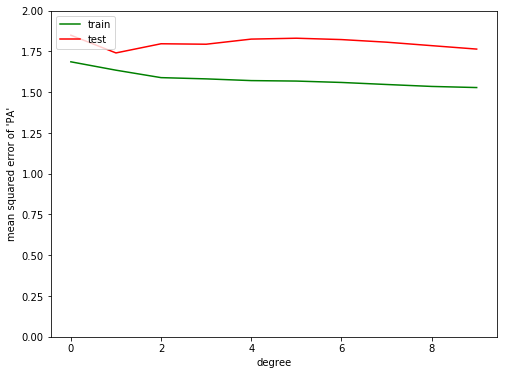

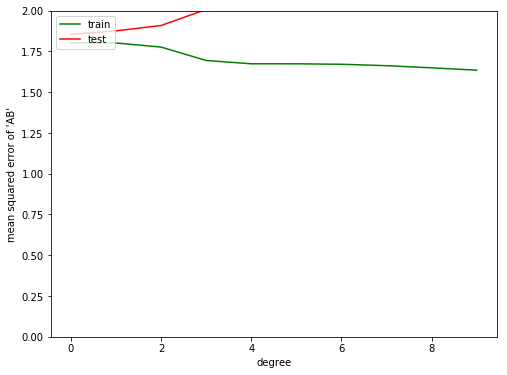

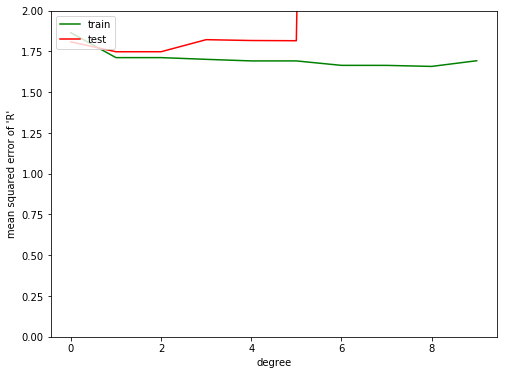

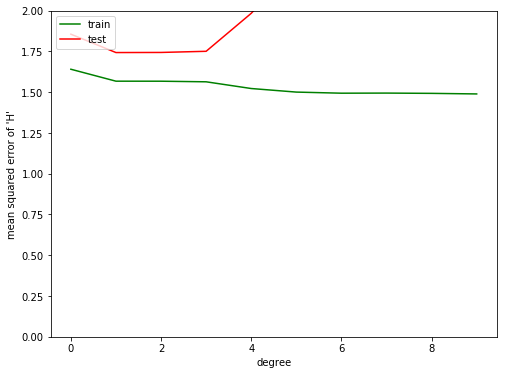

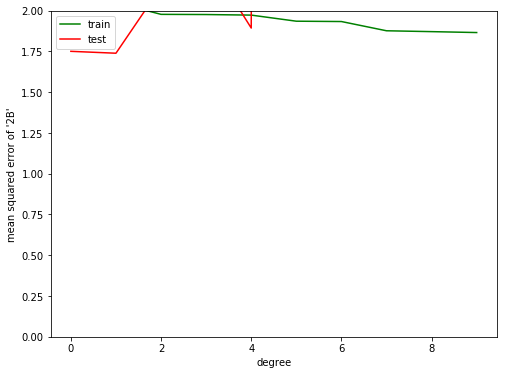

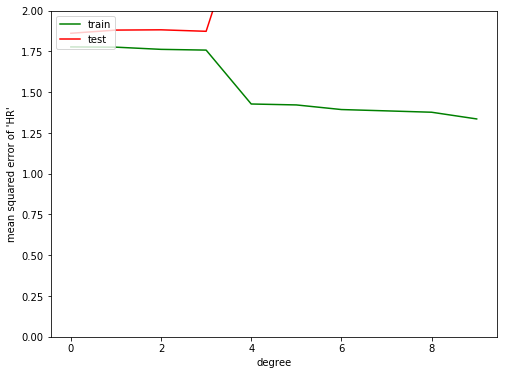

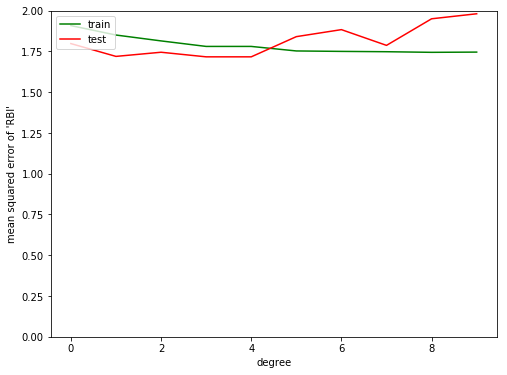

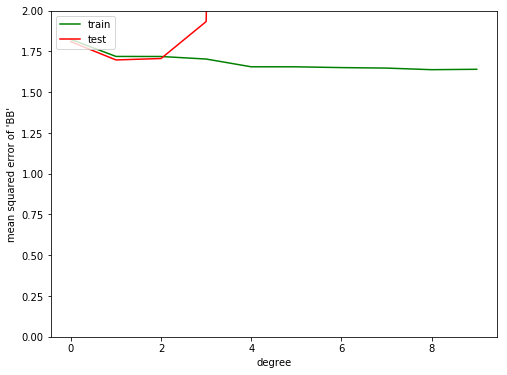

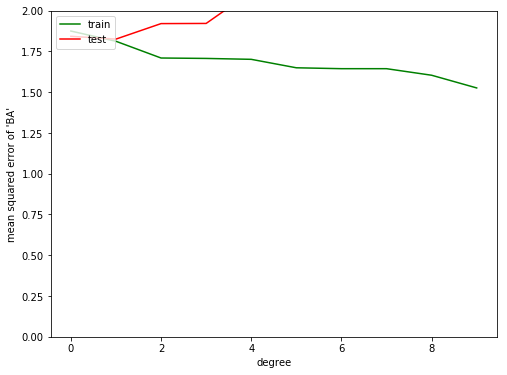

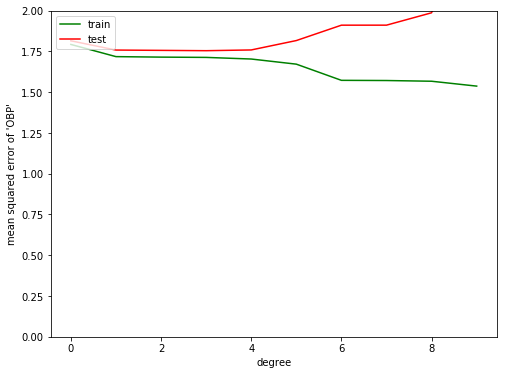

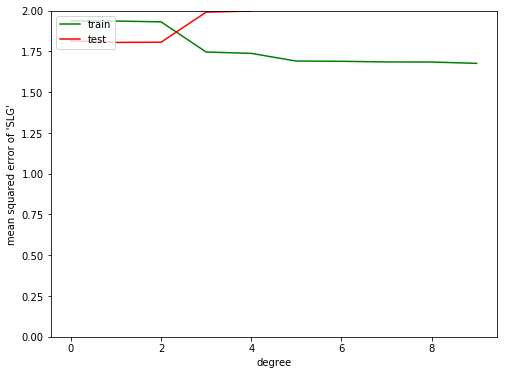

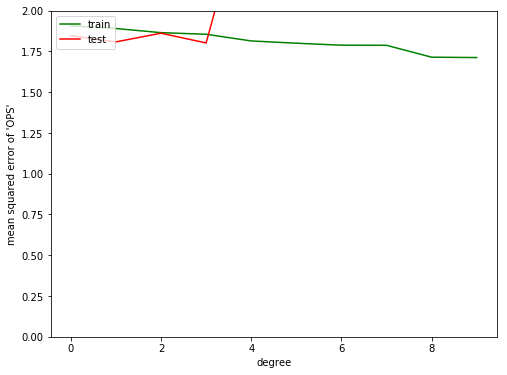

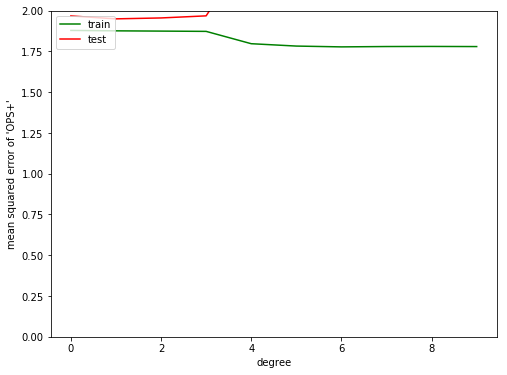

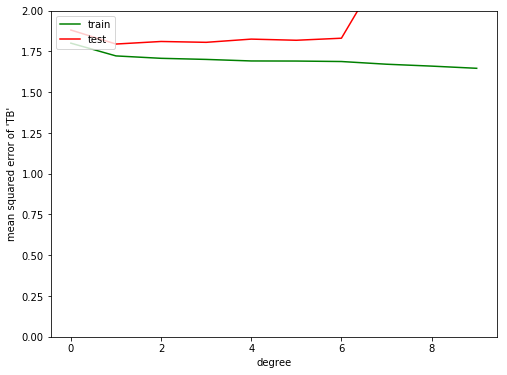

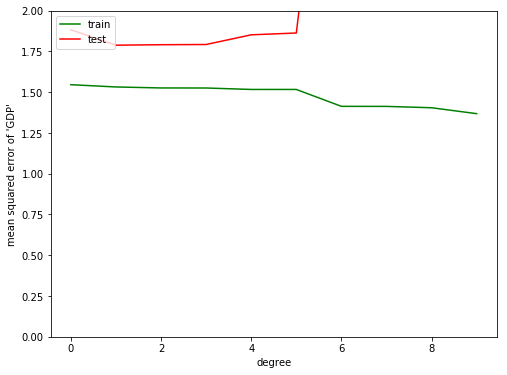

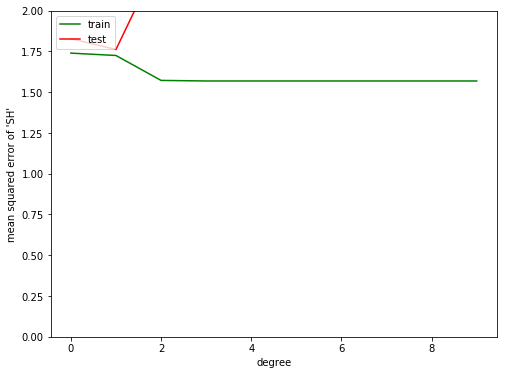

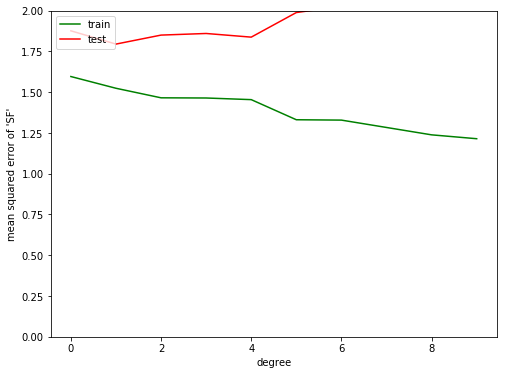

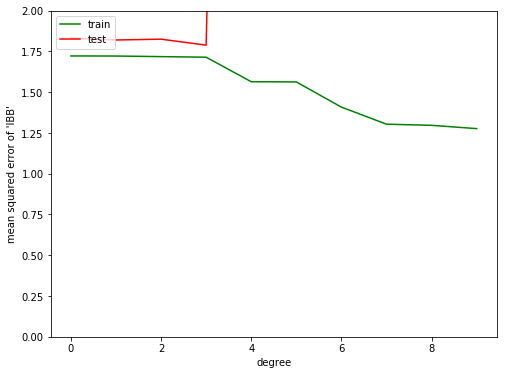

In [1206]:
for col in b1sig_cols:
    X = batdf[[col]]
    y = batdf['log_salary']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)


    # Step through degrees from 0 to 9 and store the training and test (generalization) error.
    train_error = np.empty(10)
    test_error = np.empty(10)
    for degree in range(10):
        est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        est.fit(X_train, y_train)
        train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
        test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

    # Plot the training and test errors against degree
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(10), train_error, color='green', label='train')
    plt.plot(np.arange(10), test_error, color='red', label='test')
    plt.ylim((0, 2))
    plt.ylabel('mean squared error of %r' %col)
    plt.xlabel('degree')
    plt.legend(loc='upper left')

According to the graphs above, the test error can be imporved by the transformation of the variables; Age, BB and OPS+.

In [1207]:
batdf['age_sqrd'] = batdf['Age'] ** 2
batdf['BB_sqrd'] = batdf['BB'] ** 2
batdf['OPS+_sqrd'] = batdf['OPS+'] ** 2
batdf['RBI_sqrd'] = batdf['RBI'] ** 2
batdf['RBI_cube'] = batdf['RBI'] ** 3
batdf['H_sqrd'] = batdf['H'] ** 2



In [1208]:
est=LinearRegression()
x = batdf.drop(['Salary','Name', 'log_salary'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = batdf['log_salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.02: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
bsig_cols = sig_cols
print(bsig_cols)
print(np.mean(all_scores))

['Age', 'PA', 'AB', 'R', 'H', '2B', 'HR', 'RBI', 'BB', 'OBP', 'TB', 'GDP', 'SH', 'SF', 'IBB', 'age_sqrd', 'BB_sqrd', 'OPS+_sqrd', 'RBI_sqrd', 'RBI_cube', 'H_sqrd']
0.552040444553


/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [1209]:
x = batdf[bsig_cols]
y = batdf['log_salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(lr, y, lr.predict(x)))
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
zipped=zip(x.columns,lr.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]

Fit score (R^2) is: 0.640715
Adj R^2 is: 0.612771
Fit intercept is: 0.435940
Mean of the target value is: 14.892948


[('OBP', -16.064570837540227),
 ('Age', 0.92997262900730349),
 ('SH', -0.08817623695914853),
 ('IBB', 0.053489429048114524),
 ('SF', 0.04560973751997871),
 ('H', 0.043857405142832963),
 ('BB', 0.035643414232700316),
 ('HR', 0.019965145500571737),
 ('GDP', 0.01878139805875444),
 ('TB', -0.018358857293105608)]

Text(336.971,0.5,'Predicted outcome')

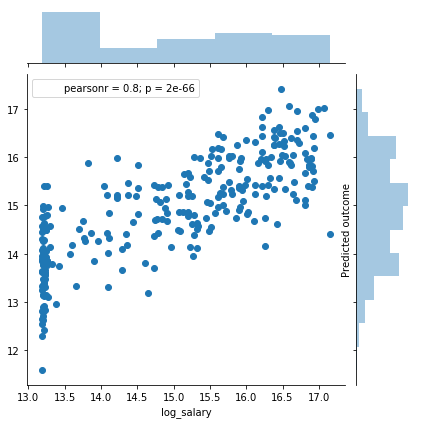

In [1210]:
y_predicted = lr.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

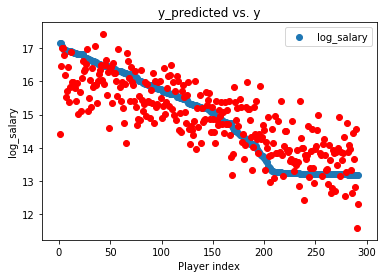

In [1211]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('log_salary')
plt.title('y_predicted vs. y')
plt.legend()

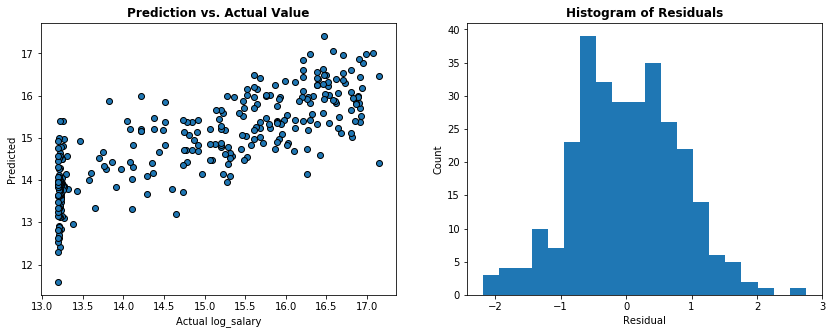

In [1212]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');




### Pitching

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


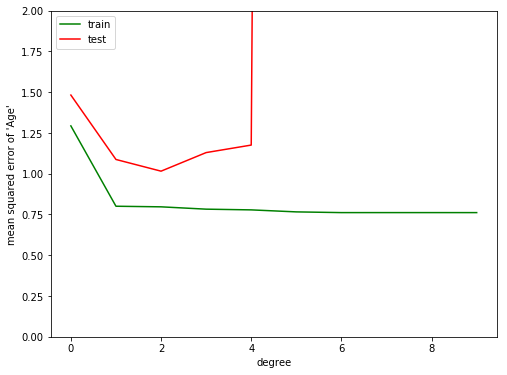

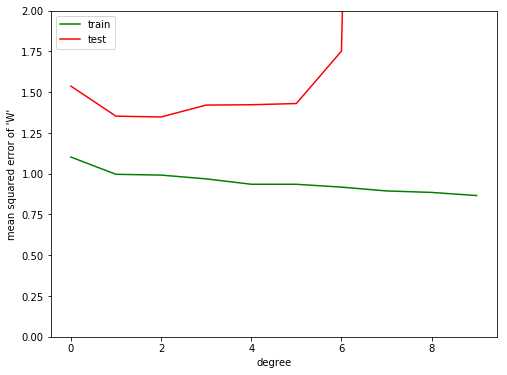

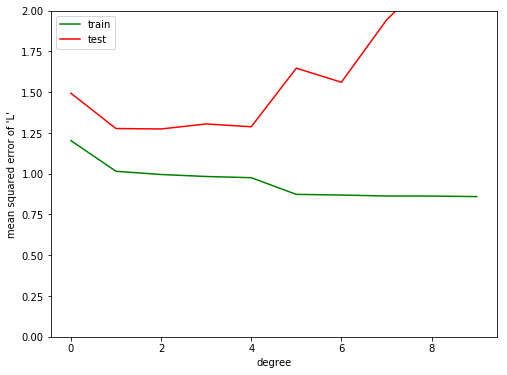

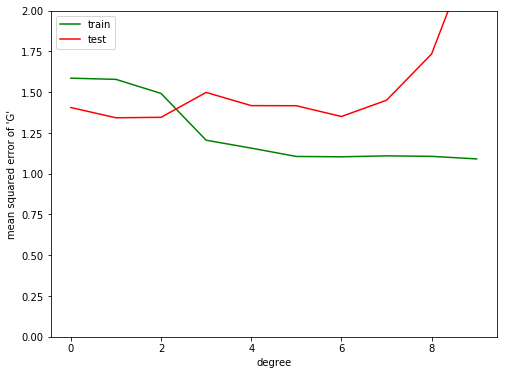

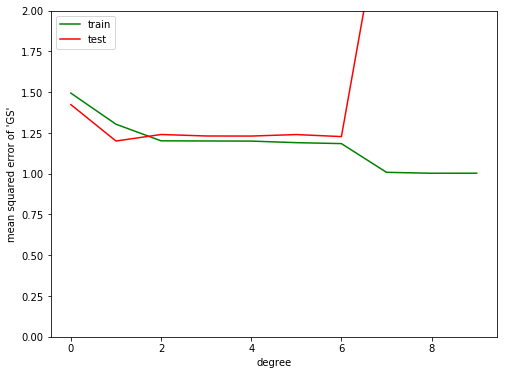

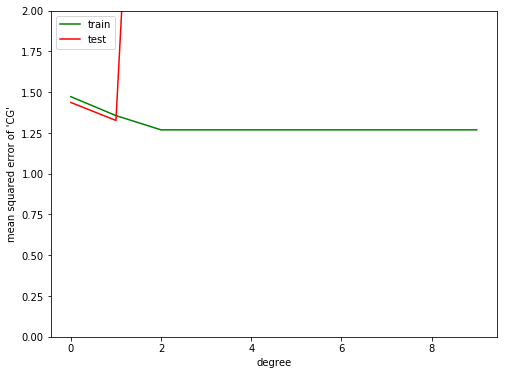

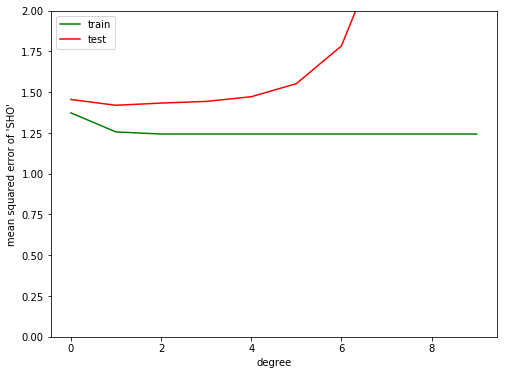

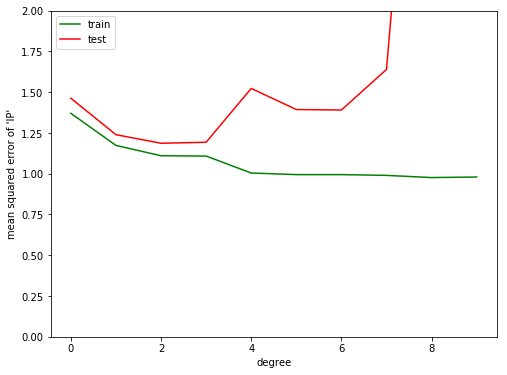

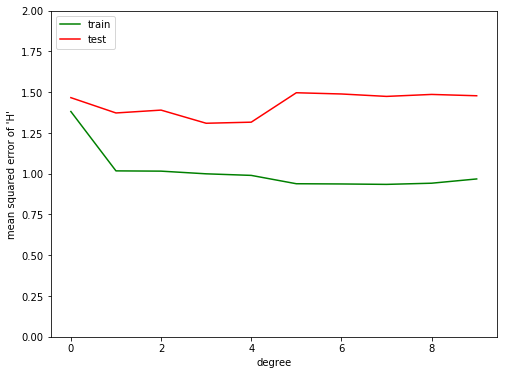

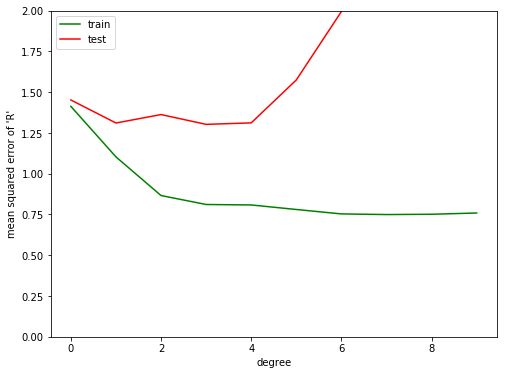

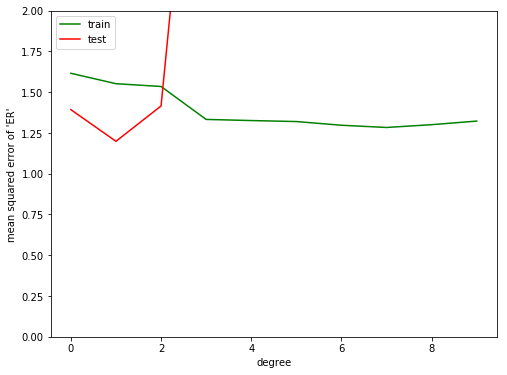

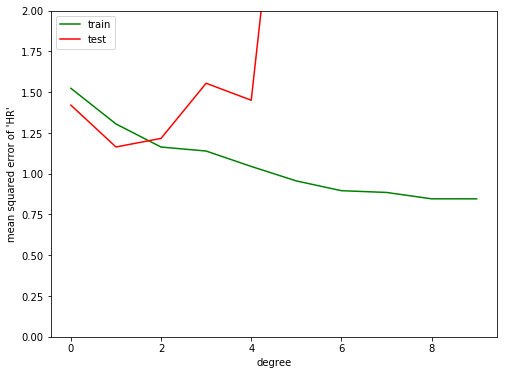

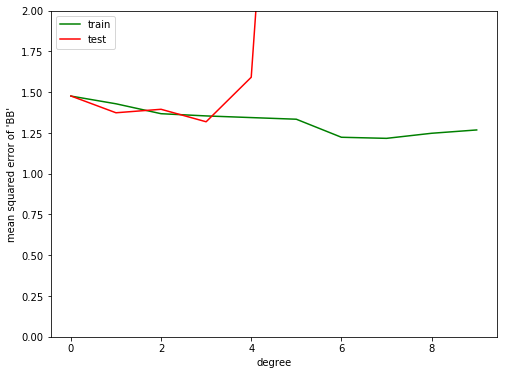

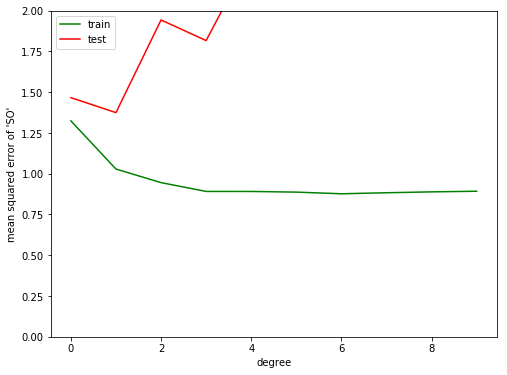

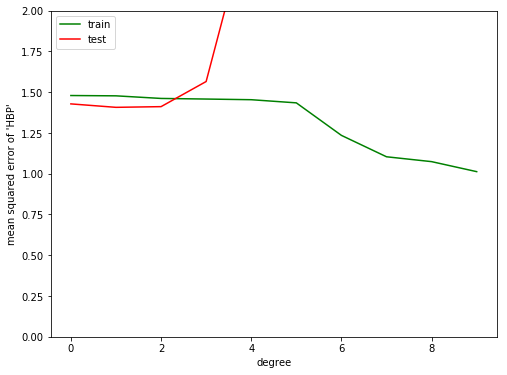

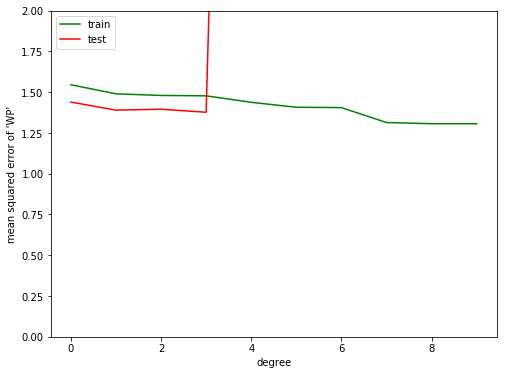

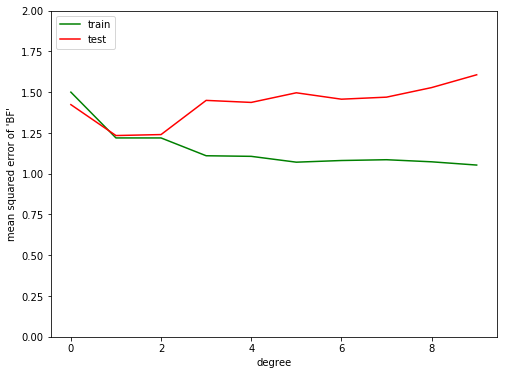

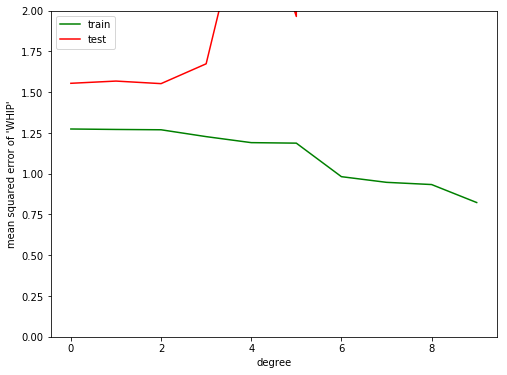

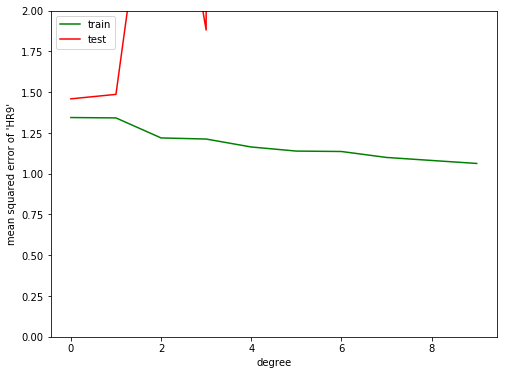

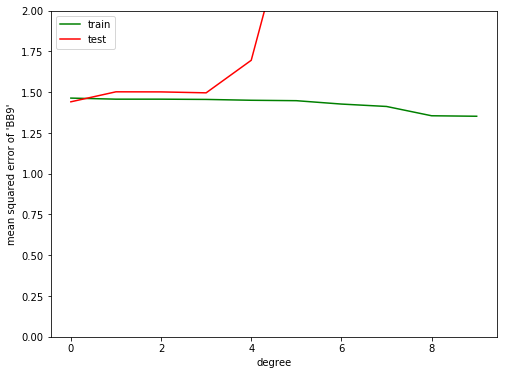

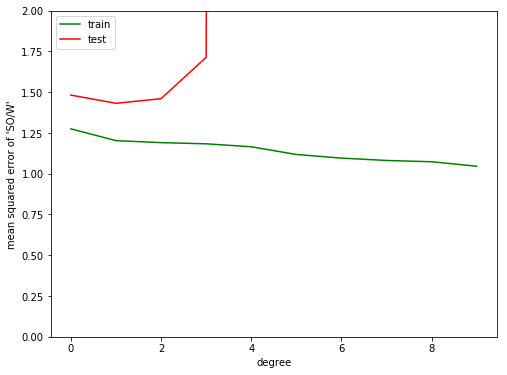

In [1213]:
for col in p1sig_cols:
    X = pitchdf[[col]]
    y = pitchdf['log_salary']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)


    # Step through degrees from 0 to 9 and store the training and test (generalization) error.
    train_error = np.empty(10)
    test_error = np.empty(10)
    for degree in range(10):
        est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        est.fit(X_train, y_train)
        train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
        test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

    # Plot the training and test errors against degree
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(10), train_error, color='green', label='train')
    plt.plot(np.arange(10), test_error, color='red', label='test')
    plt.ylim((0, 2))
    plt.ylabel('mean squared error of %r' %col)
    plt.xlabel('degree')
    plt.legend(loc='upper left')

In [1214]:
pitchdf['age_sqrd'] = pitchdf['Age'] ** 2
pitchdf['w_sqrd'] = pitchdf['W'] ** 2
pitchdf['GS_sqrd'] = pitchdf['GS'] ** 2
pitchdf['GF_sqrd'] = pitchdf['GF'] ** 2
pitchdf['GF_cube'] = pitchdf['GF'] ** 3
pitchdf['GF_quad'] = pitchdf['GF'] ** 4
pitchdf['CG_sqrd'] = pitchdf['CG'] ** 2
pitchdf['H_sqrd'] = pitchdf['H'] ** 2
pitchdf['H_cube'] = pitchdf['H'] ** 3
pitchdf['ER_sqrd'] = pitchdf['ER'] ** 2
pitchdf['ER_cube'] = pitchdf['ER'] ** 3
pitchdf['HR_sqrd'] = pitchdf['HR'] ** 2
pitchdf['BB9_sqrd'] = pitchdf['BB9'] ** 2
pitchdf['SO/W_sqrd'] = pitchdf['SO/W'] ** 2

In [1215]:
est=LinearRegression()
x = pitchdf.drop(['Salary','Name', 'log_salary'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = pitchdf['log_salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.00001: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
psig_cols = sig_cols
print(psig_cols)
print(np.mean(all_scores))

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


['Age', 'W', 'L', 'GS', 'IP', 'H', 'R', 'ER', 'HR', 'SO', 'BF', 'age_sqrd', 'w_sqrd', 'GS_sqrd', 'H_sqrd', 'H_cube', 'ER_sqrd', 'ER_cube', 'HR_sqrd']
0.525946582476


In [1216]:
x = pitchdf[psig_cols]
y = pitchdf['log_salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(lr, y, lr.predict(x)))
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
zipped=zip(x.columns,lr.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]


Fit score (R^2) is: 0.623989
Adj R^2 is: 0.589806
Fit intercept is: -0.011040
Mean of the target value is: 14.554615


[('Age', 0.8906715391432467),
 ('ER', -0.096167566616364678),
 ('L', 0.094977716917228616),
 ('R', 0.04718920500839241),
 ('IP', 0.046296934031048731),
 ('GS', -0.019413585399963441),
 ('BF', -0.018685757656319316),
 ('HR', -0.014374709930817471),
 ('age_sqrd', -0.011786224960962554),
 ('SO', 0.010354597400928381)]

Text(336.971,0.5,'Predicted outcome')

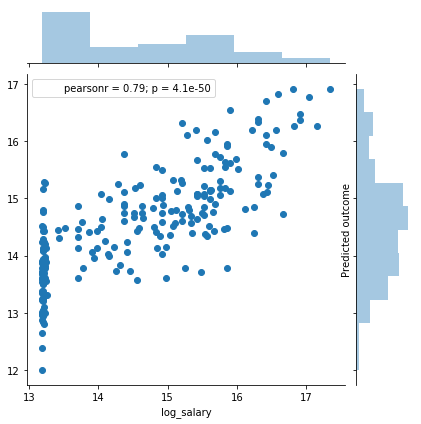

In [1217]:
y_predicted = lr.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

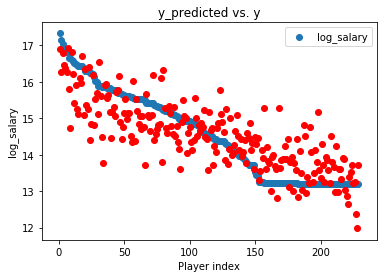

In [1218]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('log_salary')
plt.title('y_predicted vs. y')
plt.legend()

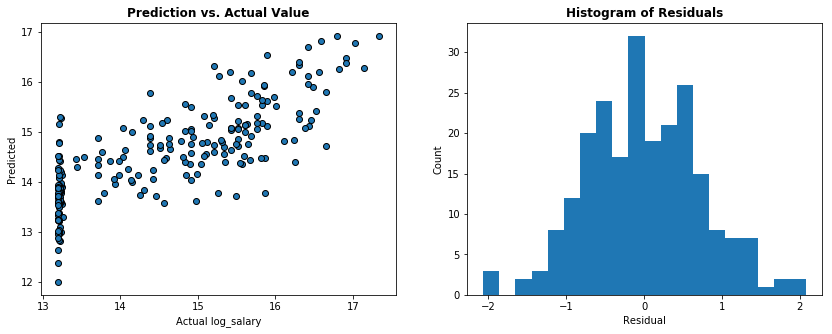

In [1219]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');

# Regularization

In this section I will attempt to regularize my model using ridge, lasso, and ridgeCV which uses lasso ridge and elastic regularization. 

### Batting

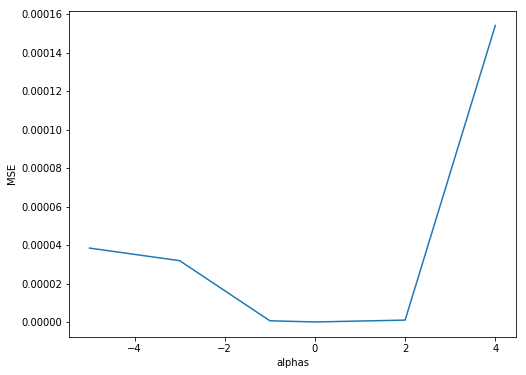

In [1220]:
x = batdf[bsig_cols]
y = batdf['log_salary']
alphas=[1e-5,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

def make_estimator(est,alpha):
    est.alpha=alpha
    model = est.fit(X_train,y_train)
    mse=np.mean(y_test-model.predict(X_test))**2
    return mse
    
# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()



In [1221]:
# A bit more involved approach: illustrated here with Lasso
kf = KFold(n=len(x), n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]


for train, test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)
#all_scores

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  app.launch_new_instance()
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


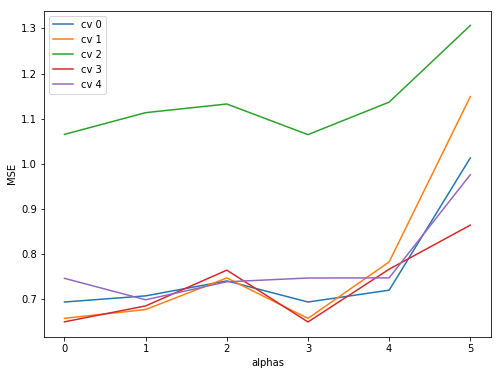

In [1222]:
# Which alpha is the best for our model ? Looks like alpha= 1
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [1223]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

est=Lasso(alpha=1e-3)
est.fit(X_train,y_train)
est.alpha


zipped=zip(x.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:]



/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[('Age', 1.0001324631714044),
 ('IBB', 0.05373961292901077),
 ('SF', 0.034778991703774978),
 ('BB', 0.02110132703834448),
 ('R', 0.013657870822918835),
 ('H', 0.011427459674632479),
 ('HR', 0.0064253982421921992),
 ('2B', 0.0060449563956966748),
 ('AB', 0.0049199179980633249),
 ('RBI_sqrd', 0.00021817890855257684),
 ('OPS+_sqrd', 5.3347887769536875e-05),
 ('H_sqrd', 2.9247468651996249e-05),
 ('RBI_cube', -7.3200457126433897e-07),
 ('BB_sqrd', -0.00013502572682802863),
 ('PA', -0.0037109294830009031),
 ('GDP', -0.0065787590763689901),
 ('age_sqrd', -0.012391143637184054),
 ('TB', -0.014501151621821326),
 ('RBI', -0.018835357039746214),
 ('SH', -0.10740980892098946),
 ('OBP', -6.2320938207792285)]

In [1224]:
print(est.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(est, y, est.predict(x)))

0.625264346672
Adj R^2 is: 0.596118


In [1225]:
# As we saw before, here is our baseline r^2 score
lr=LinearRegression()
#x = batdf.drop(['Name', 'Salary','log_salary'])
#y = batdf['log_salary']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

lr.fit(xtrain, ytrain)
print(lr.score(xtest, ytest))
print('Adj R^2 is: %f'%adj_r2_score(lr, ytest, lr.predict(xtest)))

0.583222223236
Adj R^2 is: 0.450611


In [1226]:
rcv = RidgeCV(cv=10)
rcv.fit(x, y)
print(rcv.score(xtest, ytest))
print('Adj R^2 is: %f'%adj_r2_score(rcv, ytest, rcv.predict(xtest)))

0.654261223998
Adj R^2 is: 0.544253


In [1227]:
zipped=zip(x.columns,rcv.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]

[('Age', 0.64646904841386454),
 ('SF', 0.074005775178755978),
 ('SH', -0.072424686090593188),
 ('IBB', 0.053758633903774306),
 ('HR', 0.026688188437716257),
 ('BB', 0.024871461183366382),
 ('OBP', -0.022433982520820499),
 ('AB', 0.022302386142721377),
 ('PA', -0.019605483534504864),
 ('GDP', 0.018380377026759587)]

In [1228]:
#couldn't figure out why stats model would give me very high R^2 and adj R^2 so I decided not to use it at all.
model = sm.OLS(y,x)

fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4425.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        09:07:48   Log-Likelihood:                -351.49
No. Observations:                 292   AIC:                             745.0
Df Residuals:                     271   BIC:                             822.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.9490      0.106      8.987      0.000       0.741       1.157
PA            -0.0023      0.015     -0.153      0.878      -0.031       0.027
AB            -0.0022      0.017     -0.132      0.895      -0.036       0.031
R              0.0178      0.007      2.423      0.016       0.003       0.032
H              0.0425      0.025      1.678      0.094      -0.007       0.092
2B             0.0002      0.017      0.013      0.990      -0.033       0.033
HR             0.0201      0.047      0.427      0.670      -0.072       0.112
RBI            0.0140      0.027      0.516      0.606      -0.039       0.067
BB             0.0355      0.016      2.214      0.028       0.004       0.067
OBP          -15.5088      5.815     -2.667      0.008     -26.956      -4.061
TB            -0.0184      0.016     -1.174      0.241      -0.049       0.012
GDP            0.0186      0.014      1.325      0.186      -0.009       0.046
SH            -0.0877      0.041     -2.162      0.032      -0.168      -0.008
SF             0.0470      0.034      1.398      0.163      -0.019       0.113
IBB            0.0538      0.019      2.846      0.005       0.017       0.091
age_sqrd      -0.0118      0.002     -6.504      0.000      -0.015      -0.008
BB_sqrd       -0.0002   8.74e-05     -2.248      0.025      -0.000   -2.44e-05
OPS+_sqrd   6.262e-05   3.59e-05      1.745      0.082   -8.04e-06       0.000
RBI_sqrd      -0.0003      0.000     -0.734      0.463      -0.001       0.001
RBI_cube    1.665e-06   2.03e-06      0.821      0.412   -2.33e-06    5.66e-06
H_sqrd     -1.906e-05   4.32e-05     -0.441      0.659      -0.000     6.6e-05
==============================================================================
Omnibus:                        0.201   Durbin-Watson:                   1.180
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.080
Skew:                           0.031   Prob(JB):                        0.961
Kurtosis:                       3.053   Cond. No.                     5.90e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.9e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(336.971,0.5,'Predicted outcome')

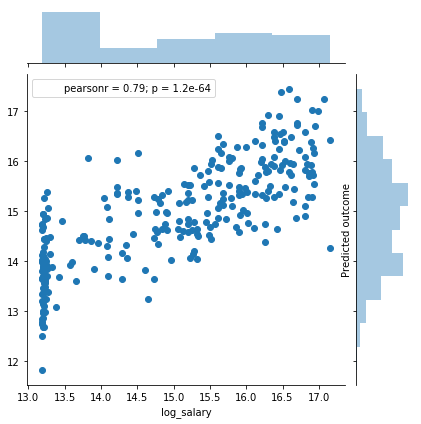

In [1229]:
y_predicted = rcv.predict(x)
predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
plt.ylabel('Predicted outcome')

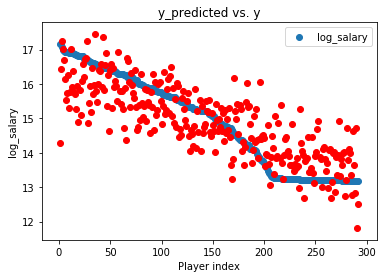

In [1230]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('log_salary')
plt.title('y_predicted vs. y')
plt.legend()

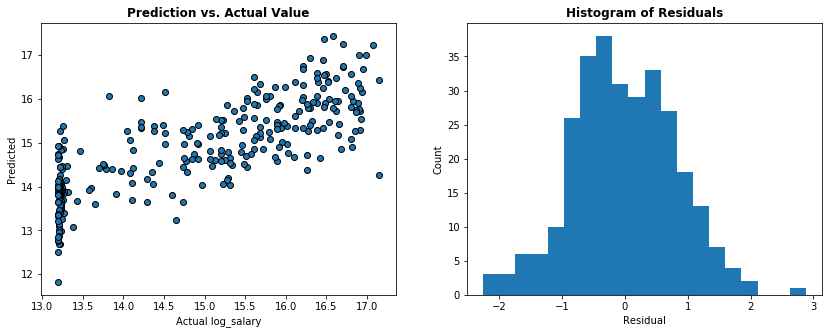

In [1231]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');

### Pitching

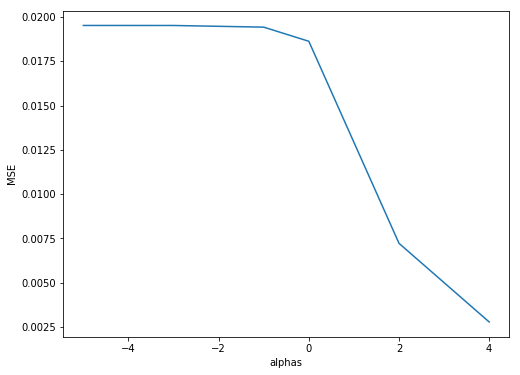

In [1232]:
x = pitchdf[psig_cols]
y = pitchdf['log_salary']
alphas=[1e-5,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [1233]:
# A bit more involved approach: illustrated here with Lasso
kf = KFold(n=len(x), n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]


for train, test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)
#all_scores

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  app.launch_new_instance()
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


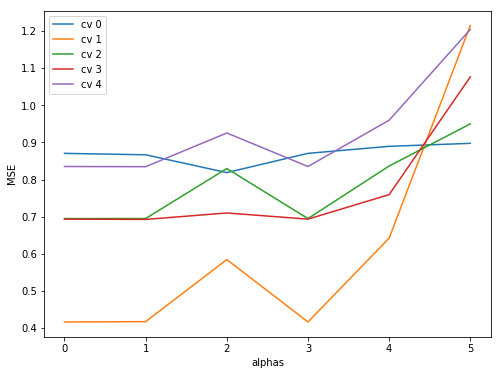

In [1234]:
# Which alpha is the best for our model ? Looks like alpha= 1
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [1235]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

est=Lasso(alpha=0)
est.fit(X_train,y_train)
est.alpha


zipped=zip(x.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:]

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[('Age', 0.918805734259588),
 ('L', 0.090049029416704257),
 ('R', 0.042380728689310344),
 ('IP', 0.024955210352365278),
 ('W', 0.016127215221657921),
 ('SO', 0.013426027694769558),
 ('GS_sqrd', 0.0013363380418245014),
 ('HR_sqrd', 0.0011112522868233371),
 ('ER_sqrd', 0.00091237815556110158),
 ('w_sqrd', 0.0006145532386183293),
 ('H_sqrd', 0.00016526813165347251),
 ('H_cube', -4.233648900325861e-07),
 ('ER_cube', -5.3205505461057185e-06),
 ('GS', -0.0024157108937006969),
 ('age_sqrd', -0.012235662507274389),
 ('BF', -0.013021267129431616),
 ('H', -0.0207738467806221),
 ('HR', -0.03091094409438587),
 ('ER', -0.064887134220928872)]

In [1236]:
print(est.score(x,y))
print('Adj R^2 is: %f'%adj_r2_score(est, y, est.predict(x)))

0.613105027813
Adj R^2 is: 0.577933


In [1252]:
# As we saw before, here is our baseline r^2 score
lr=LinearRegression()
#x = batdf.drop(['Name', 'Salary','log_salary'])
#y = batdf['log_salary']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

lr.fit(xtrain, ytrain)
print(lr.score(xtest, ytest))
print('Adj R^2 is: %f'%adj_r2_score(lr, ytest, lr.predict(xtest)))

0.534398120381
Adj R^2 is: 0.353859


In [1238]:
rcv = RidgeCV(cv=10)
rcv.fit(x, y)
print(rcv.score(xtest, ytest))
print('Adj R^2 is: %f'%adj_r2_score(rcv, ytest, rcv.predict(xtest)))

0.660889020692
Adj R^2 is: 0.529397


In [1240]:
zipped=zip(x.columns,rcv.coef_)
features=sorted(zipped,key = lambda t: np.abs(t[1]),reverse=True)
features[:10]

[('Age', 0.62428972792989124),
 ('ER', -0.098466836917560821),
 ('L', 0.09415432851551235),
 ('R', 0.047039965200607034),
 ('IP', 0.046390476343467955),
 ('GS', -0.021977746171265803),
 ('BF', -0.018672447688793465),
 ('HR', -0.01570770864866386),
 ('W', -0.011835468128439094),
 ('SO', 0.010607685707486086)]

In [1241]:
y_predicted = rcv.predict(x)

Text(336.971,0.5,'Predicted outcome')

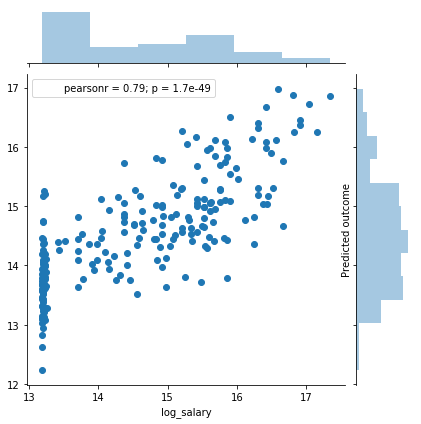

In [1242]:
predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)

plt.ylabel('Predicted outcome')


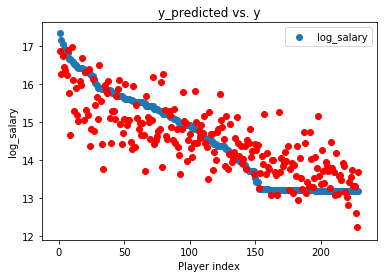

In [1243]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')
plt.xlabel('Player index')
plt.ylabel('log_salary')
plt.title('y_predicted vs. y')
plt.legend()

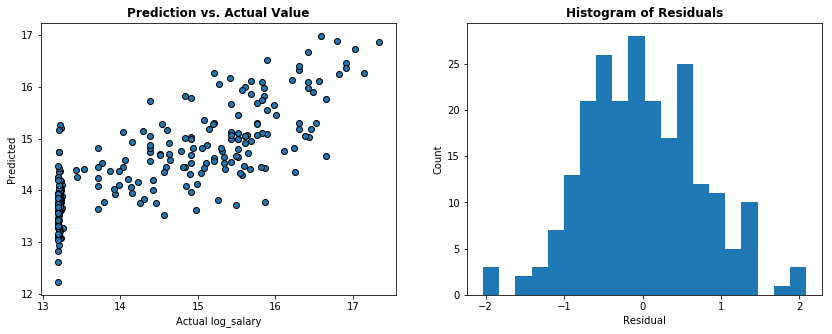

In [1244]:
yp = y_predicted
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual log_salary')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');